<center>Final Project<center>
Using Sentiment Analysis and Recurrent Neural Networks to Idenfify Fake News<br>
By Graham Chickering

 One of the biggest issues facing society today is the increasing prevalence of fake news that can be found all across social media and across the internet. It is getting harder and harder to discern between what is real and what is fake, and it leaves people either questioning the truth and scientific knowledge or outright believing things that are not true. With people getting more and more of their news from social media such as Facebook and Twitter, the high amount of fake news on these platforms is deeply concerning and finding ways to decrease the spread of fake information is one of the most pressing issues that society and people working within the technology sector are facing. It has been said that false claims are 70% more likely to be shared on Twitter than real news, so finding ways to identify fake news early on before it can be spread has important consequences for what the future of society and democracy looks like.

For my project it is exactly this issue of identifying fake news that my project focuses on. With the large amounts of fake news article that are already pervasive on the internet, the recent developments in machine learning appear to be one of the best ways to identify fake news sources and prevent them from spreading and further eroding people’s confidence in what is true. By working with a large Fake News dataset that has over 20000 articles, split roughly even between fake news articles and real news articles, that contains not only the content of the articles but the authors and title of the articles I am planning to apply this dataset to be able to create models that are able to distinguish between the two types of news.
    
Before I create the models themselves, I first start by creating a wordcloud of the top 500 words found in both the fake news articles and real news articles, just to get a high level understanding of what some of the key words might be when trying to detect real vs fake news. The second task I take on is applying preprocessing techniques to clean the text, removing stop words, and applying techniques such as stemming and lemmanization, which will later prove useful in building the models themselves. Stemming and Lemmanization are two techniques often used in sentiment analysis projects such as this one that help to transform words into their root words in the case of stemming, or to their correct canonical form in the case of lemmanization. By first converting words to their correct base, this will later ensure that the models are only dealing with the correct root word. 


Finally after getting every text article cleaned up, I then try out two different types of models, Logistic Regression and a LSTM Recurrent Neural Network model, to see which can ultimately do better on this specific task. By comparing a more common type of model in the case of the Logistic Regression Model with a more advanced model such as the LSTM model, I learn not only how a LSTM model works, but also get to compare the two models to see which does best on this particular task. 


In [30]:
#pip install nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#pip install tensorflow
#pip install tensorflow_datasets
#pip install wordcloud
#pip install tensorflow_tex
#pip install keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords


from nltk import word_tokenize

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_datasets as tfds

from wordcloud import WordCloud


import keras
from keras import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [2]:
news=pd.read_csv("train.csv")
news

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


Cleaning Data and Exploratory Data Analysis

In [3]:
dataTypeSeries = news.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
id         int64
title     object
author    object
text      object
label      int64
dtype: object


In [4]:
news.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
news.fillna('Currently Missing',inplace=True)
news.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

These steps were to check to see what type of data was missing from the dataset, and instead of removing all the rows that had some value missing, I instead filled in all the missing values with a string labeled "Currently Missing". This was to avoid having to remove close to 2000 articles from the dataset. 

In [6]:
news_counts=news["label"].value_counts()
news_counts

1    10413
0    10387
Name: label, dtype: int64

Here we can see that there is a very even split between real and fake news articles in the dataset

In [7]:
author_counts=news["author"].value_counts()
author_counts

Currently Missing                    1957
Pam Key                               243
admin                                 193
Jerome Hudson                         166
Charlie Spiering                      141
                                     ... 
Jess Bidgood and Alan Blinder           1
DAVID E. SANGER                         1
Julia Preston and Jennifer Medina       1
Dan Bilefsky and Palko Karasz           1
Sharon LaFraniere and Mitch Smith       1
Name: author, Length: 4202, dtype: int64

Here we can get an idea of what type authors have multiple articles in the dataset. While the number of missing authors is the highest, we can see that Pam Key has 243 articles herself in this dataset.

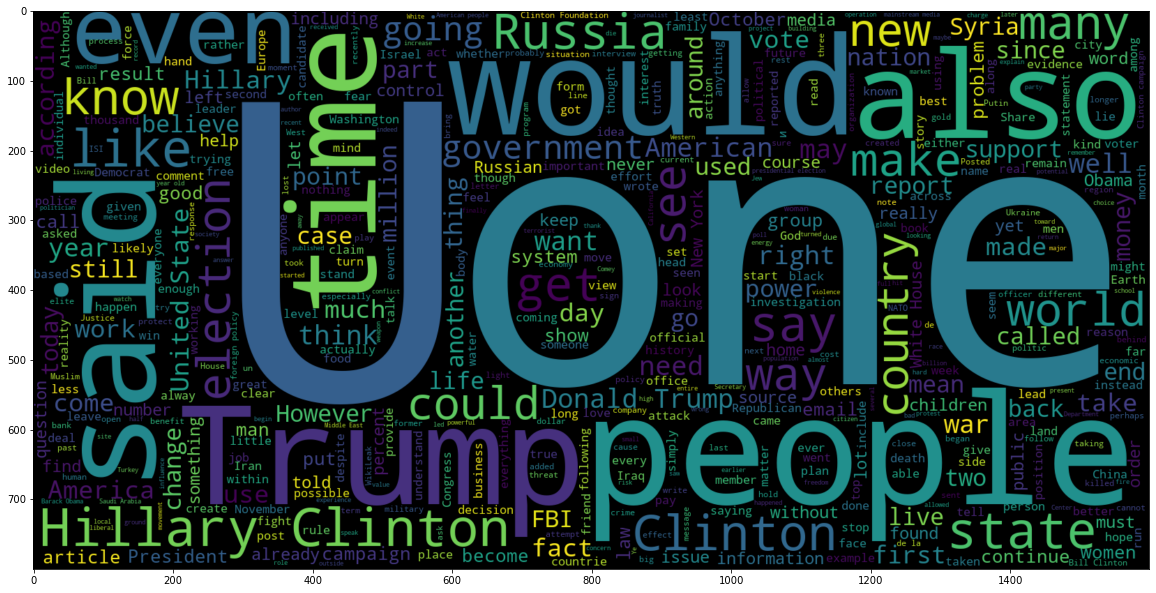

In [8]:
fake_news=news[news["label"]==1]

stop_words = stopwords.words('english')

plt.figure(figsize=(20,20))
wordCloud = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(fake_news["text"]))
plt.imshow(wordCloud, interpolation = 'bilinear')

When looking at a wordcloud of the top 500 words from all the fake news articles, we can start to get a sense of what type of words tend to make up this article. Very quickly one will notice the prevalence of political words and names such as Trump, Hillary Clinton, Russia, election, and government. This may give us an idea that many fake news articles are very politically motivated and so this may mean that any political news article should be more closely screened as to whether or not its fake news.

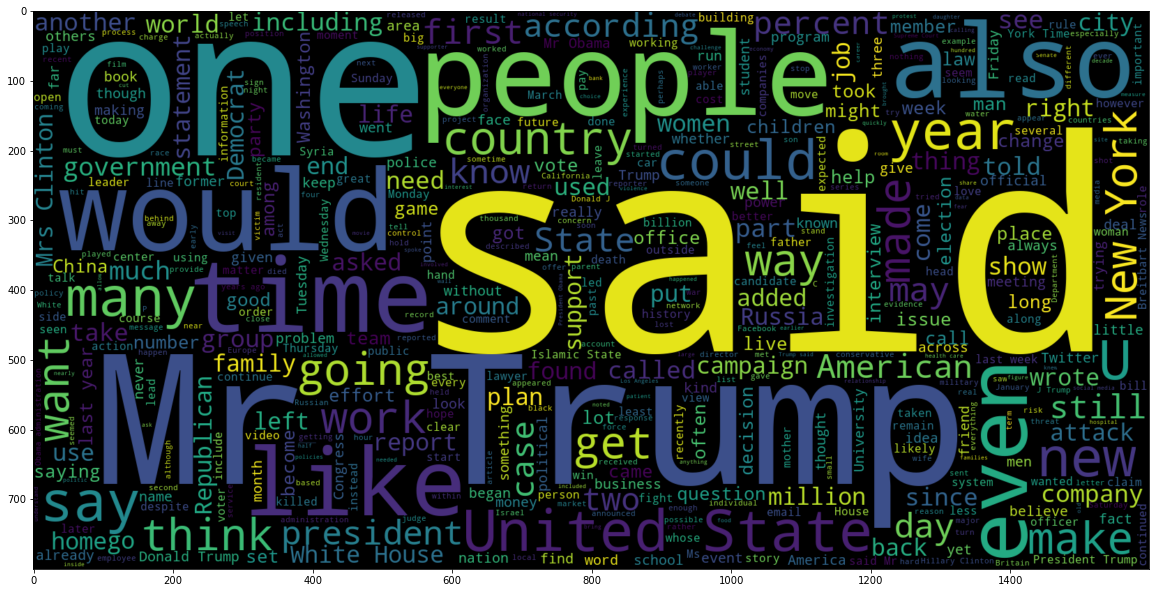

In [9]:
real_news=news[news["label"]==0]

plt.figure(figsize=(20,20))
wordCloud = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(real_news["text"]))
plt.imshow(wordCloud, interpolation = 'bilinear')

When looking at this wordcloud of the top 500 words from real news articles, we can start to compare to the previous wordcloud. We can see that Trump is still one of the top words but should notice that Hilary Clinton is no longer one of the top words. We can also see how words such as country and president are now top words. This could tell us that articles about Hilary Clinton tend to be fake news whereas articles about Trump may tell a more accurate story. Overall though from looking at these two wordcloud together, one can see see how the prevalence of how this dataset is likely made up of predominantly political news articles, both real and fake. 

In [10]:
text1=news.iloc[0, news.columns.get_loc('text')]
text1

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

This was a check to see an an example of the actual content of one of the articles and to see what sort of cleaning of the article that will have to be done. We can see that there will be a little bit of cleaning required for the documents.

Cleaning the Data

In [11]:
stemmer=SnowballStemmer("english", ignore_stopwords=True)

def tokenizer_stemmer(text):
    return[stemmer.stem(word) for word in text.split()]

tokenizer_stemmer(text1)

['hous',
 'dem',
 'aide:',
 'we',
 "didn't",
 'even',
 'see',
 'comey',
 'letter',
 'until',
 'jason',
 'chaffetz',
 'tweet',
 'it',
 'by',
 'darrel',
 'lucus',
 'on',
 'octob',
 '30,',
 '2016',
 'subscrib',
 'jason',
 'chaffetz',
 'on',
 'the',
 'stump',
 'in',
 'american',
 'fork,',
 'utah',
 '(',
 'imag',
 'courtesi',
 'michael',
 'jolley,',
 'avail',
 'under',
 'a',
 'creativ',
 'commons-bi',
 'license)',
 'with',
 'apolog',
 'to',
 'keith',
 'olbermann,',
 'there',
 'is',
 'no',
 'doubt',
 'who',
 'the',
 'worst',
 'person',
 'in',
 'the',
 'world',
 'is',
 'this',
 'week–fbi',
 'director',
 'jame',
 'comey.',
 'but',
 'accord',
 'to',
 'a',
 'hous',
 'democrat',
 'aide,',
 'it',
 'look',
 'like',
 'we',
 'also',
 'know',
 'who',
 'the',
 'second-worst',
 'person',
 'is',
 'as',
 'well.',
 'it',
 'turn',
 'out',
 'that',
 'when',
 'comey',
 'sent',
 'his',
 'now-infam',
 'letter',
 'announc',
 'that',
 'the',
 'fbi',
 'was',
 'look',
 'into',
 'email',
 'that',
 'may',
 'be',
 're

In [12]:
lemmatizer = WordNetLemmatizer() 

def lemmanizer(text):
    return[lemmatizer.lemmatize(word) for word in text.split() if not word in stop_words]

newtext=lemmanizer(text1)
newtext

['House',
 'Dem',
 'Aide:',
 'We',
 'Didn’t',
 'Even',
 'See',
 'Comey’s',
 'Letter',
 'Until',
 'Jason',
 'Chaffetz',
 'Tweeted',
 'It',
 'By',
 'Darrell',
 'Lucus',
 'October',
 '30,',
 '2016',
 'Subscribe',
 'Jason',
 'Chaffetz',
 'stump',
 'American',
 'Fork,',
 'Utah',
 '(',
 'image',
 'courtesy',
 'Michael',
 'Jolley,',
 'available',
 'Creative',
 'Commons-BY',
 'license)',
 'With',
 'apology',
 'Keith',
 'Olbermann,',
 'doubt',
 'Worst',
 'Person',
 'The',
 'World',
 'week–FBI',
 'Director',
 'James',
 'Comey.',
 'But',
 'according',
 'House',
 'Democratic',
 'aide,',
 'look',
 'like',
 'also',
 'know',
 'second-worst',
 'person',
 'well.',
 'It',
 'turn',
 'Comey',
 'sent',
 'now-infamous',
 'letter',
 'announcing',
 'FBI',
 'looking',
 'email',
 'may',
 'related',
 'Hillary',
 'Clinton’s',
 'email',
 'server,',
 'ranking',
 'Democrats',
 'relevant',
 'committee',
 'didn’t',
 'hear',
 'Comey.',
 'They',
 'found',
 'via',
 'tweet',
 'one',
 'Republican',
 'committee',
 'chairmen

Here we compare different types of lemmanizers vs snowball stemming algorithms on an article. By scanning through the two new sets of words, we can see that overall the lemmanizer appears to do a slightly better job of maintaining the correct word. Therefore I will use the lemmanizer algorithm and apply it to the entire dataset.

In [13]:
stop_words = stopwords.words('english')

def text_lemmanizer(article_text):

    article_text = re.sub('[^a-zA-Z]', ' ', article_text)
    article_text = article_text.lower().split()
    article_txt = [lemmatizer.lemmatize(word) for word in article_text if word not in stop_words]
    article_text = ' '.join(article_text)
    article_text = ''.join(p for p in article_text if p not in punctuation)
    
    return article_text

Beyond just applying a lemmanizer to all the articles. I also wanted to clean the data further. In the function above I remove all numbers, convert all the words to lower case and then also remove all the common stop words from the dataset. This will be useful when I go to create the models so that only the most significant words get passed in

In [14]:
## This will take a while to run
news['lemmatized_text'] = news['text'].apply(text_lemmanizer)

In [15]:
news['lemmatized_text']

0        house dem aide we didn t even see comey s lett...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october the ...
3        videos civilians killed in single us airstrike...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macy s of today grew from the union of sev...
20798    nato russia to hold parallel exercises in balk...
20799    david swanson is an author activist journalist...
Name: lemmatized_text, Length: 20800, dtype: object

Now that the data has been cleaned and preprocessed it is ready to be used to create a model. 

Logistic Regression 

In [16]:
X=news['lemmatized_text'].values
y=news['label'].values

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=2)

In [17]:
tfidf=TfidfVectorizer(strip_accents=None, lowercase=True, preprocessor=None)

param_grid= [{'vect__ngram_range':[(1,1)],
              'clf__penalty': ['l1','l2'],
              'clf__C':[1.0,10.0,100.0]},
             {'vect__ngram_range':[(1,1)],
              'vect__use_idf':[False],
              'vect__norm':[None],
              'clf__penalty': ['l1','l2'],
              'clf__C':[1.0,10.0,100.0]}
            ]

lr_tfidf=Pipeline([('vect',tfidf),
                  ('clf', LogisticRegression(random_state=0,solver='liblinear'))])

gs_lr_tfidf=GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv=5,verbose=2, n_jobs=1)



For the logistic regression model I first use the TfidfVectorizer function, which allows me to first convert each word in a document to an individual token and then it calculates the tf-idf score for each document as well. The tf-idf score is essentially a ratio of how significant each word is in relation to other documents. I then apply the grid search algorithm to find out the best possible C value and which regularization penalty to use. This will all allow me to find the best possible logistic regression model for the data. 

In [18]:
##This takes roughly 10 minutes to run
gs_lr_tfidf.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1) ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), total=   7.4s
[CV] clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1) ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), total=   7.7s
[CV] clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1) ...........
[CV]  clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), total=   7.4s
[CV] clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1) ...........
[CV]  clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), total=   7.3s
[CV] clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1) ...........
[CV]  clf__C=1.0, clf__penalty=l1, vect__ngram_range=(1, 1), total=   7.2s
[CV] clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1) ...........
[CV]  clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), total=   7.4s
[CV] clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1) ...........
[CV]  clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), total=   7.3s
[CV] clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1) ...........
[CV]  clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), total=   7.4s
[CV] clf__C=1.0, clf__penalty=l2, vect__ngram_ran

[CV]  clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False, total=  13.6s
[CV] clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False 
[CV]  clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False, total=   7.5s
[CV] clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False 
[CV]  clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False, total=   7.6s
[CV] clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False 
[CV]  clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False, total=   7.3s
[CV] clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False 
[CV]  clf__C=100.0, clf__penalty=l1, vect__ngram_range=(1, 1), vect__norm=None, vect__use_idf=False, total=   7.7s
[CV] clf__C=100.0, clf__pe

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)]},
                         {'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)], 'vect__norm': [None],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=2)

In [19]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' %gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1)} 
CV Accuracy: 0.959


After running the previous code, I find that the best hyperparameters for this model involve using a C value of 100 and using the l2 regularization penalty. I also use a 1 word gram model in order to keep the training time down on the model. 

In [20]:
clf=gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' %clf.score(X_test, y_test))

Test Accuracy: 0.960


After finding the best hyperparameters for the model. I then wanted to apply and test the model on the testing set. I find that this logistic regression model is able to achieve an accruacy score of 96.0%, implying that this model is able to do an extremely accurate job of detecting whether or not an article is real or fake. 

Now that I had created a logistic regression model. I now wanted to create a LSTM model.

LSTM Model (Recurrent Neural Network)

In [21]:
features=news['lemmatized_text']
target=news['label']

In [22]:
vocab_size = 10000
embedding_dim = 128

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(features)
train_sequences = tokenizer.texts_to_sequences(features)
padded_train = pad_sequences(train_sequences,maxlen = 50, padding = 'post', truncating = 'post')

Here I am converting all the words in the "lemmatized_text" column of the dataset into individual tokens for each of the unique words in the articles. In this process I select only the top 10000 words from all the articles and convert it into a sequence of integers. I then use the pad_sequence function to connvert the new sequence into a 2D numpy array. 

In [23]:
x_final=np.array(padded_train)
y_final=np.array(target)

X_train, X_test, y_train, y_test=train_test_split(x_final, y_final, test_size=0.3, random_state=2)

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

Above is the best model I was able to create using a LSTM model. By first using an embedding layer, which is a feature-learning technique, this allows the model to learn the salient and important words and features from the articles. I then apply a LSTM layer, which although slightly complicated to fully explain, has been shown to work extremely well for modeling long sequences such as text articles. This layer helps to remember the important features and words from the previous inputs, which is what allows it to be successful with complicated sequence tasks such as this one. Then I apply three dropout and dense layers, to try to prevent overfitting and as well make sure the entire model is connected. 

In [25]:
history = model.fit(X_train, y_train, batch_size = 64, validation_split = 0.3, epochs = 5)

Epoch 1/5
160/160 [==============================] - 22s 136ms/step - loss: 0.3627 - accuracy: 0.8337 - val_loss: 0.2318 - val_accuracy: 0.9148
Epoch 2/5
160/160 [==============================] - 22s 140ms/step - loss: 0.1459 - accuracy: 0.9561 - val_loss: 0.2833 - val_accuracy: 0.9171
Epoch 3/5
160/160 [==============================] - 22s 134ms/step - loss: 0.0782 - accuracy: 0.9765 - val_loss: 0.3682 - val_accuracy: 0.9071
Epoch 4/5
160/160 [==============================] - 21s 133ms/step - loss: 0.0509 - accuracy: 0.9881 - val_loss: 0.3481 - val_accuracy: 0.9132
Epoch 5/5
160/160 [==============================] - 22s 135ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.3717 - val_accuracy: 0.9125


When running this model, we can see how the model's accuracy drastically increases after the first epoch but then stays around the same through the final 4 epochs. We can also see from this output that the model still may be slightly overfitting the data, as the accuracy on the training set is always slightly higher than the accuracy on the validation set. Overall though we can be happy with seeing this model being able to achieve roughly 91% accuracy on the validation set. 

In [32]:
model_predictions=model.predict_classes(X_test)

In [33]:
print(accuracy_score(y_test,model_predictions))

0.9056089743589744


From this result we can see that this particular LSTM model is able to achieve 90.56% accuracy on the testing set. 

Conclusions and Future Work

By first cleaning up the text data, removing stop words, and then converting all the words in the articles to their root lemma, this allow both models to be very successful in being able to predict whether an article was real or fake. 
When comparing the Logistic Regression Model and the LSTM model, the Logistic Regression Model does a better job of making accurate predictions on this data set. Overall one can see that the logistic regression model was able to achieve on accuracy of 96.0% on the testing set, whereas the LSTM model was only able to achieve an accuracy of 90.4% on the testing set. Overall both these models do an extremely good job of being able to predict whether or not an article should be classified as real or fake news. 

While being able to achieve scores as high on 96% and 90.4% is very exciting on its own, this project could be built on heavily on the future. Firstly, while I tried to create many different models using the LSTM and the embedding layers, there is other types of LSTM models that could be explored in the future. By potentially trying out differing types of LSTM variations or even trying out a more recent approach such as a Gated Recurrent Unit (GRU) model, I could hope to improve the accuracy of this particular type of model even further. I could also have tried with the Logistic Regression model different sizes of bag of word models, beyond just the one word sized model. 

Beyond just ways to increase the accuracy of the models themselves, the work done in this project could be used heavily to start identifying news articles outside of the one in this dataset. Being able to detect and remove fake news articles early on from sites such as Twitter or Facebook has huge societal implications, and maintaining faith in science and the truth in general, and using these types of models could be one way to begin trying to solve this issue. By utilizing these types of models to detect fake news articles early on could help prevent the spread of fake news and help people begin relying on more trusted sources in the future. 

Works Cited

“Fake News.” Kaggle, www.kaggle.com/c/fake-news. 

Phi, Michael. “Illustrated Guide to LSTM's and GRU's: A Step by Step Explanation.” Medium, Towards Data Science, 28 June 2020, towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21. 

Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning. Packt Publishing Limited, 2015. 

Sinha, Nimesh. “Understanding LSTM and Its Quick Implementation in Keras for Sentiment Analysis.” Medium, Towards Data Science, 3 Mar. 2018, towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47. 